## TV Commercial Detection
Below are the steps to import the source data for pre-processing before modelling in MATLAB.

## A - Data Import

In [68]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

# Library required for converting libsvm data file
# https://pypi.org/project/libsvm/
!pip install libsvm
from libsvm.svmutil import *

In [69]:
import pickle
# Function to serialise object
def save_pickle(file_nm, obj):
    pickle_out = open(file_nm, 'wb')
    pickle.dump(obj, pickle_out)
    pickle_out.close()

# Function to load object from pickle file
def load_pickle(file_nm):
    pickle_in = open(file_nm, 'rb')
    obj = pickle.load(pickle_in)
    return obj

### Read in the source file and wrangle into a data frame

In [70]:
src_y, src_x = svm_read_problem('BBC.txt')

In [71]:
src_y_df = pd.DataFrame(src_y)
src_x_df = pd.DataFrame(src_x)
# Add x prefix to independent variables

# Rename dependent variable to y
src_x_df.columns = ['x' + str(col) for col in list(src_x_df.columns)]
src_y_df.columns = ['y']
src_df = pd.concat([src_y_df, src_x_df], axis=1)
src_df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x779,x128,x689,x1119,x324,x694,x88,x785,x198,x487
0,1.0,123.0,1.316440,1.516003,5.605905,5.346760,0.013233,0.010729,0.091743,0.050768,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,124.0,0.966079,0.546420,4.046537,3.190973,0.008338,0.011490,0.075504,0.065841,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,109.0,2.035407,0.571643,9.551406,5.803685,0.015189,0.014294,0.094209,0.044991,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,86.0,3.206008,0.786326,10.092709,2.693058,0.013962,0.011039,0.092042,0.043756,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,76.0,3.135861,0.896346,10.348035,2.651010,0.020914,0.012061,0.108018,0.052617,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Define data frame for the categories of independent variables
The source data contained 230 independent variables which are mapped to a set of categories per the description provided by the donor Guha et al:
https://archive.ics.uci.edu/ml/datasets/TV+News+Channel+Commercial+Detection+Dataset

In summary:

| Variable IDs | Feature description |
|--------------|---------------------|
|y | Advertising or programming classification |
| x1, ..., x3 | Motion distribution* |
| x4, x5 | Frame difference* |
| x6, x7 | Short time energy* |
| x8, x9 | Zero Crossing Rate (ZCR)* |
| x10, x11 | Spectral Centroid* |
| x12, x13 | Spectral Roll off* |
| x14, x15 | Spectral Flux* |
| x16, x17 | Fundamental Frequency* |
| x18, …, x58 | Motion Distribution stratified into 40 bins |
| x59, …, x90 |Frame Difference Distribution stratified into 32 bins |
| x91, …, x105 |Text Area Distribution Mean stratified into 15 bins |
| x105, …, x123 | Text Area Distribution Variance stratified into 15 bins |
| x125, …, x1119 | Bag of Audio Words into 109 bins** |
| x4124, x4125 |Edge Change Ratio* |


In [72]:
src_x_data_dct_df = pd.DataFrame(src_x_df.columns)
src_x_data_dct_df.columns = ['variable']

# Function for a given variable name to return feature type based on the specification above
def lookup_feature_type(var_nm):
    if var_nm == 'y':
        desc = 'classification'
    else:
        # Get number from the variable name, e.g. 1 from x1
        x = int(var_nm[1:])
        # Look up x variable number to return category
        if x <= 3:
            desc = 'Motion distribution'
        elif x <= 5:
            desc = 'Frame difference'
        elif x <= 7:
            desc = 'Short time energy'
        elif x <= 9:
            desc = 'Zero Crossing rate'
        elif x <= 11:
            desc = 'Spectral centroid'
        elif x <= 13:
            desc = 'Spectral roll off'
        elif x <= 15:
            desc = 'Spectral flux'
        elif x <= 17:
            desc = 'Fundamental frequency'
        elif x <= 58:
            desc = 'Motion distribution - bins'
        elif x <= 90:
            desc = 'Frame difference - bins'
        elif x <= 105:
            desc = 'Text area mean - bins'
        elif x <= 123:
            desc = 'Text area variance - bins'
        elif x <= 1119:
            desc = 'Audio bag of words - bins'
        elif x <= 4125:
            desc = 'Edge change ratio'
    return desc

src_x_data_dct_df['variable_cat'] = src_x_data_dct_df['variable'].apply(lookup_feature_type)
src_x_data_dct_df.head()

,variable,variable_cat
0,x1,Motion distribution
1,x2,Motion distribution
2,x3,Motion distribution
3,x4,Frame difference
4,x5,Frame difference


## B - Exploratory Data Analysis

Review the data completeness of each variable:

a) response variable *y*

In [73]:
# Summary of binary classification by count
print('Total observations: {}'.format(src_y_df.shape[0]))
src_y_df['tally'] = [1] * src_y_df.shape[0]
y_summary_df = src_y_df.groupby('y').count()
y_summary_df.reset_index(inplace=True)
y_summary_df = y_summary_df[['y', 'tally']]
y_summary_df['pct'] = y_summary_df['tally']/src_df.shape[0]
y_summary_df

Total observations: 17720


,y,tally,pct
0,-1.0,9304,0.525056
1,1.0,8416,0.474944


The above shows a split in the binary classificaitons of 53:47 for not advertising and advertising respectively.  There were no null entries.

b) independent variables *x1,...,x4125*

In [74]:
# Count the number of records that are not null NaN
x_summary_df = src_x_df.describe().T
x_summary_df['count_pct'] = x_summary_df['count']/src_x_df.shape[0]
x_summary_df.reset_index(inplace=True)

# Summarise by completeness % in 25 percentage points bins
x_summary_df['count_pct'] = x_summary_df['count'] / src_x_df.shape[0]
x_summary_df['count_bin'] = pd.cut(x_summary_df['count_pct'], bins=[0, 0.25, 0.5, 0.75, 1.0])
x_summary_df = x_summary_df.groupby('count_bin').count()
x_summary_df.reset_index(inplace=True)
x_summary_df = x_summary_df[['count_bin', 'count']]
x_summary_df['count_pct'] = x_summary_df['count'] / x_summary_df['count'].sum()
x_summary_df

,count_bin,count,count_pct
0,"(0.0, 0.25]",86,0.373913
1,"(0.25, 0.5]",32,0.139130
2,"(0.5, 0.75]",58,0.252174
3,"(0.75, 1.0]",54,0.234783


The above summary shows that only 23% of the independent variables had 75% of more data points within.  Other independent variables appear to have 25% of higher 

In [75]:
# Normalise each independent variable by min and max of each variable
def normalise_variable(series):
    # Calculate min and max of the variable
    var_min = series.min()
    var_max = series.max()
    
    # Normalise each value in variable
    def normalise_val(val, mn, mx):
        # Where value is None, then return None
        if val is None or mn is None or mx is None:
            return None
        # Where value is NaN return NaN
        elif np.isnan(val) or np.isnan(mn) or np.isnan(mx):
            return np.NaN
        # Where min and max difference is not zero (no division by zero error), normalise value
        elif mn - mx != 0:
            return (val - mn) / (mx - mn)
        # Return zero (where there is division by zero error)
        else:
            return 0
        return new_val
    
    return pd.Series([normalise_val(val, var_min, var_max) for val in series])

src_x_norm_df = src_x_df

for nm in src_x_df.columns:
    src_x_norm_df[nm] = normalise_variable(src_x_norm_df[nm])

src_x_norm_df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x779,x128,x689,x1119,x324,x694,x88,x785,x198,x487
0,0.002895,0.060724,0.052718,0.083315,0.084338,0.374862,0.500981,0.232525,0.222193,0.957332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.002925,0.044562,0.019002,0.060140,0.050334,0.236197,0.536515,0.191367,0.288162,0.871404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.002482,0.093887,0.019879,0.141953,0.091546,0.430271,0.667445,0.238775,0.196909,0.954850,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.001802,0.147884,0.027344,0.149998,0.042480,0.395513,0.515456,0.233283,0.191504,0.945678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.001507,0.144648,0.031170,0.153792,0.041816,0.592448,0.563177,0.273774,0.230285,0.951404,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17715,0.001211,0.123890,0.104951,0.203136,0.271109,0.406589,0.365101,0.302296,0.262848,0.944759,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17716,0.000236,0.073699,0.035061,0.080519,0.046603,0.450214,0.352680,0.318737,0.242965,0.885996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17717,0.000000,0.067595,0.024420,0.086921,0.056377,0.546812,0.455781,0.253769,0.254585,0.841303,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17718,0.001861,0.030846,0.042971,0.063068,0.169906,0.518965,0.307947,0.281355,0.191320,0.956011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [76]:
# Create a melted summary data frame of descriptive statistics
x_summary_melted_df = src_x_norm_df.describe().T
x_summary_melted_df['count_pct'] = x_summary_melted_df['count']/src_x_df.shape[0]
x_summary_melted_df.reset_index(inplace=True)
x_summary_melted_df.rename(columns={'index': 'variable'}, inplace=True)
x_summary_melted_df = x_summary_melted_df.melt(id_vars='variable', var_name='stat', value_name='value')
x_summary_melted_df['label'] = x_summary_melted_df['variable'] + '_' + x_summary_melted_df['stat']

# Merge (by left join) with the definition above to obtain the type description of each variable
x_summary_melted_df = x_summary_melted_df.merge(src_x_data_dct_df, how='left', left_on='variable', right_on='variable')
x_summary_melted_df

,variable,stat,value,label,variable_cat
0,x1,count,17720.000000,x1_count,Motion distribution
1,x2,count,17720.000000,x2_count,Motion distribution
2,x3,count,17720.000000,x3_count,Motion distribution
3,x4,count,17720.000000,x4_count,Frame difference
4,x5,count,17720.000000,x5_count,Frame difference
...,...,...,...,...,...
2065,x694,count_pct,0.000113,x694_count_pct,Audio bag of words - bins
2066,x88,count_pct,0.000395,x88_count_pct,Frame difference - bins
2067,x785,count_pct,0.000903,x785_count_pct,Audio bag of words - bins
2068,x198,count_pct,0.000056,x198_count_pct,Audio bag of words - bins


     variable       stat     value           label               variable_cat
1840       x1  count_pct  1.000000    x1_count_pct        Motion distribution
1841       x2  count_pct  1.000000    x2_count_pct        Motion distribution
1842       x3  count_pct  1.000000    x3_count_pct        Motion distribution
1843       x4  count_pct  1.000000    x4_count_pct           Frame difference
1844       x5  count_pct  1.000000    x5_count_pct           Frame difference
...       ...        ...       ...             ...                        ...
2035     x220  count_pct  0.039729  x220_count_pct  Audio bag of words - bins
2036     x229  count_pct  0.016309  x229_count_pct  Audio bag of words - bins
2037     x127  count_pct  0.055474  x127_count_pct  Audio bag of words - bins
2038     x463  count_pct  0.003499  x463_count_pct  Audio bag of words - bins
2039     x478  count_pct  0.011512  x478_count_pct  Audio bag of words - bins

[200 rows x 5 columns]


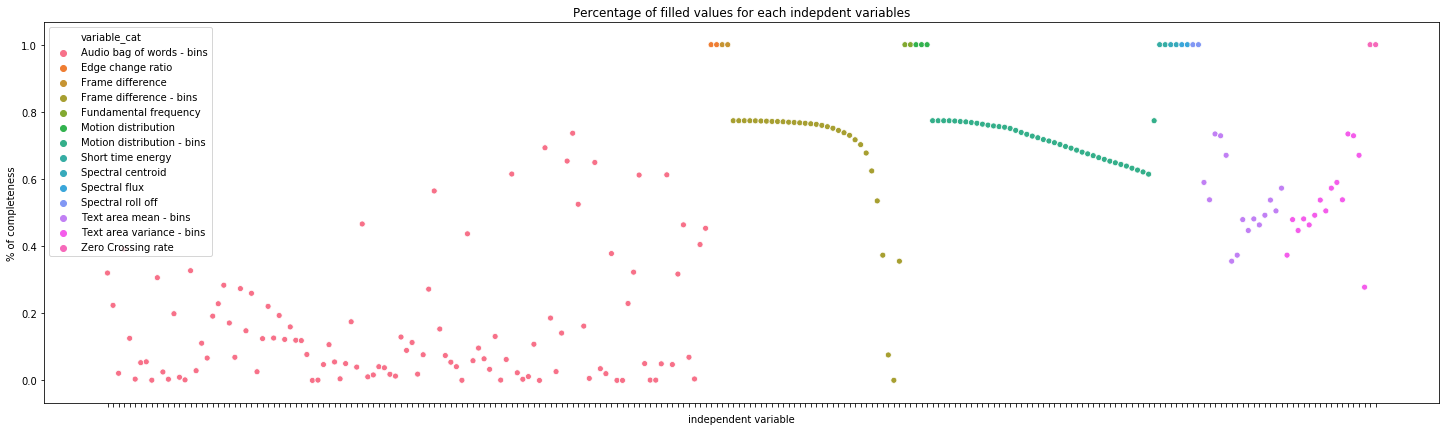

In [77]:
# Preview summary of count %
print(x_summary_melted_df[x_summary_melted_df['stat']=='count_pct'].head(200))

# Create a new data frame with the data type
x_count_pct_df = pd.DataFrame(x_summary_melted_df[x_summary_melted_df['stat']=='count_pct'])
x_count_pct_df.sort_values(by=['variable_cat', 'variable'], inplace=True)

# Plot the data count % for each independent variable
p = sns.scatterplot(data=x_count_pct_df,y='value', x='variable', hue='variable_cat')
fig_size = plt.rcParams['figure.figsize'] = [25, 7]
p.set(title='Percentage of filled values for each indepdent variables')
p.set(xlabel='independent variable', ylabel='% of completeness')
plt.gcf().set_size_inches(*fig_size)

# Remove individual variable labels due to too many to view easily
p.set(xticklabels=[])
plt.savefig('count.png')
plt.show(p)

        variable     value               variable_cat
2303600    x1002  0.009879  Audio bag of words - bins
2303601    x1002  0.009795  Audio bag of words - bins
2303602    x1002  0.007450  Audio bag of words - bins
2303603    x1002  0.019276  Audio bag of words - bins
2303604    x1002  0.005431  Audio bag of words - bins


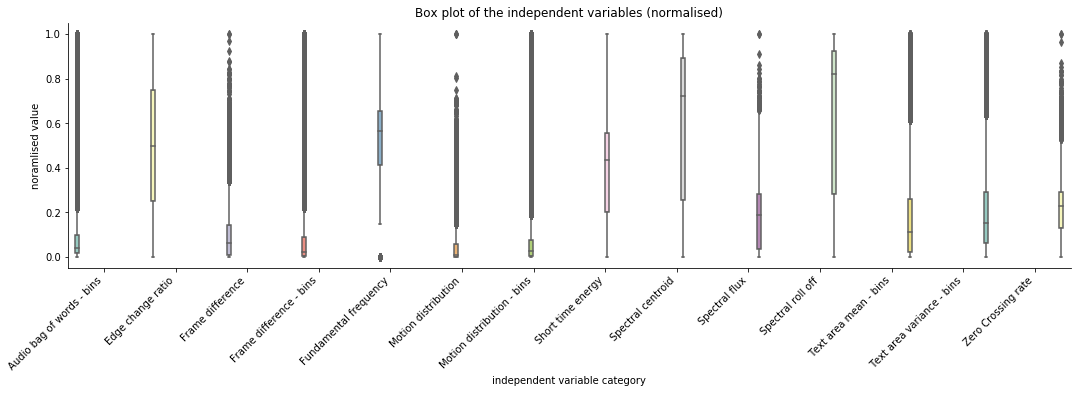

In [78]:
# Box plot on the distribution for each independent variable (after normalisation)
# Melt the data frame and obtain data type information
src_x_melted_df = src_x_norm_df.melt()
src_x_melted_df = src_x_melted_df.merge(src_x_data_dct_df, how='left', left_on='variable', right_on='variable')
src_x_melted_df.sort_values(by=['variable_cat', 'variable'], inplace=True)
print(src_x_melted_df.head())

# p = sns.boxplot(data=src_x_melted_df, x='value', y='variable', hue='variable_cat', palette='Paired')
p = sns.catplot(data=src_x_melted_df[['value', 'variable_cat']], y='value', x='variable_cat', hue='variable_cat', kind='box', palette='Set3')
fig_size = plt.rcParams['figure.figsize'] = [20, 4]
p.set(title='Box plot of the independent variables (normalised)')
p.set(ylabel='noramlised value', xlabel='independent variable category')
plt.gcf().set_size_inches(*fig_size)

# Rotate x label
# Code based on: https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='medium'  
)
p.savefig('box_plot.png')

## C - Data pre-processing

### Remove independent variables that have level of completeness
Purge independent variables with less than 75% data completeness.

In [79]:
# List independent variables with 75% completeness or above
retain_vars_df = x_summary_melted_df[x_summary_melted_df['stat']=='count_pct']
retain_vars_df = retain_vars_df[retain_vars_df['value'] >= 0.75]
print('No. of independent variables to retain {}'.format(retain_vars_df.shape[0]))
print('Category of independent variables covered:')
print(retain_vars_df['variable_cat'].drop_duplicates())
retain_vars_df

No. of independent variables to retain 54
Category of independent variables covered:
1840           Motion distribution
1843              Frame difference
1845             Short time energy
1847            Zero Crossing rate
1849             Spectral centroid
1851             Spectral roll off
1853                 Spectral flux
1855         Fundamental frequency
1857    Motion distribution - bins
1898       Frame difference - bins
1973             Edge change ratio
Name: variable_cat, dtype: object


,variable,stat,value,label,variable_cat
1840,x1,count_pct,1.000000,x1_count_pct,Motion distribution
1841,x2,count_pct,1.000000,x2_count_pct,Motion distribution
1842,x3,count_pct,1.000000,x3_count_pct,Motion distribution
1843,x4,count_pct,1.000000,x4_count_pct,Frame difference
1844,x5,count_pct,1.000000,x5_count_pct,Frame difference
1845,x6,count_pct,1.000000,x6_count_pct,Short time energy
1846,x7,count_pct,1.000000,x7_count_pct,Short time energy
1847,x8,count_pct,1.000000,x8_count_pct,Zero Crossing rate
1848,x9,count_pct,1.000000,x9_count_pct,Zero Crossing rate
1849,x10,count_pct,1.000000,x10_count_pct,Spectral centroid


In [80]:
# Purge variables with less than 75% completeness level
src_x_norm_trimmed_df = pd.DataFrame(src_x_norm_df[retain_vars_df['variable']])
print('Dimension of updated independent variables set (row, column): {}'.format(src_x_norm_trimmed_df.shape))
src_x_norm_trimmed_df.head()

Dimension of updated independent variables set (row, column): (17720, 54)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x70,x71,x72,x73,x74,x75,x76,x77,x4124,x4125
0,0.002895,0.060724,0.052718,0.083315,0.084338,0.374862,0.500981,0.232525,0.222193,0.957332,...,0.017447,0.015064,0.015062,0.012729,0.014939,0.007607,0.013679,0.016937,0.422382,0.663964
1,0.002925,0.044562,0.019002,0.060140,0.050334,0.236197,0.536515,0.191367,0.288162,0.871404,...,0.014870,0.013901,0.018879,0.018248,0.026258,0.012038,0.011112,0.007702,0.332696,0.766250
2,0.002482,0.093887,0.019879,0.141953,0.091546,0.430271,0.667445,0.238775,0.196909,0.954850,...,0.022811,0.017333,0.014204,0.009868,0.009911,0.005457,0.009975,0.010804,0.346708,0.224987
3,0.001802,0.147884,0.027344,0.149998,0.042480,0.395513,0.515456,0.233283,0.191504,0.945678,...,0.012694,0.009093,0.006842,0.002320,0.001293,0.000489,0.000875,0.000941,0.993480,0.840163
4,0.001507,0.144648,0.031170,0.153792,0.041816,0.592448,0.563177,0.273774,0.230285,0.951404,...,0.004677,0.002346,0.002258,0.002591,0.003821,0.002623,0.007116,0.005123,0.341553,0.710526


### Fill NaN with independent variable mean
Fill any NaN entries with the variable's mean (based on non-blank entries)

In [81]:
def replace_series_nan(ls):
    # Calculate variable mean (excluding NaN entries)
    mean = np.nanmean(ls)
    
    # Replace any None or NaN to variable Mean
    def replace_val_nan(val, mean):
        # Keep value if not None nor NaN
        if (val is not None and not np.isnan(val)):
            new_val = val
        # Otherwise return variable mean
        else:
            new_val = mean
        return new_val
    
    # Apply over the series by map
    new_ls = ls.map(lambda val: replace_val_nan(val, mean))
    return new_ls

src_x_norm_trimmed_df = src_x_norm_trimmed_df.apply(replace_series_nan, axis=0)
src_x_norm_trimmed_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x70,x71,x72,x73,x74,x75,x76,x77,x4124,x4125
0,0.002895,0.060724,0.052718,0.083315,0.084338,0.374862,0.500981,0.232525,0.222193,0.957332,...,0.017447,0.015064,0.015062,0.012729,0.014939,0.007607,0.013679,0.016937,0.422382,0.663964
1,0.002925,0.044562,0.019002,0.060140,0.050334,0.236197,0.536515,0.191367,0.288162,0.871404,...,0.014870,0.013901,0.018879,0.018248,0.026258,0.012038,0.011112,0.007702,0.332696,0.766250
2,0.002482,0.093887,0.019879,0.141953,0.091546,0.430271,0.667445,0.238775,0.196909,0.954850,...,0.022811,0.017333,0.014204,0.009868,0.009911,0.005457,0.009975,0.010804,0.346708,0.224987
3,0.001802,0.147884,0.027344,0.149998,0.042480,0.395513,0.515456,0.233283,0.191504,0.945678,...,0.012694,0.009093,0.006842,0.002320,0.001293,0.000489,0.000875,0.000941,0.993480,0.840163
4,0.001507,0.144648,0.031170,0.153792,0.041816,0.592448,0.563177,0.273774,0.230285,0.951404,...,0.004677,0.002346,0.002258,0.002591,0.003821,0.002623,0.007116,0.005123,0.341553,0.710526


In [82]:
# Check no NaN entries in all cells
print('No. of NaN entries in data frame after filling NAs: {}'.format(src_x_norm_trimmed_df.isna().sum().sum()))

No. of NaN entries in data frame after filling NAs: 0


Therefore no NaN entries remained.

### Save data into Excel file

After the data pre-processing above, combine the dependent and updated independent variables together into one data frame, and write to Excel file for MATLAB modelling:

In [83]:
# Append dependent and independent variables into one data frame by column axis
matlab_df = pd.concat([src_y_df['y'], src_x_norm_trimmed_df], axis=1)
print('Final dimension of the data set (rows, columns): {}'.format(matlab_df.shape))
matlab_df.head()

Final dimension of the data set (rows, columns): (17720, 55)


,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x70,x71,x72,x73,x74,x75,x76,x77,x4124,x4125
0,1.0,0.002895,0.060724,0.052718,0.083315,0.084338,0.374862,0.500981,0.232525,0.222193,...,0.017447,0.015064,0.015062,0.012729,0.014939,0.007607,0.013679,0.016937,0.422382,0.663964
1,1.0,0.002925,0.044562,0.019002,0.060140,0.050334,0.236197,0.536515,0.191367,0.288162,...,0.014870,0.013901,0.018879,0.018248,0.026258,0.012038,0.011112,0.007702,0.332696,0.766250
2,1.0,0.002482,0.093887,0.019879,0.141953,0.091546,0.430271,0.667445,0.238775,0.196909,...,0.022811,0.017333,0.014204,0.009868,0.009911,0.005457,0.009975,0.010804,0.346708,0.224987
3,1.0,0.001802,0.147884,0.027344,0.149998,0.042480,0.395513,0.515456,0.233283,0.191504,...,0.012694,0.009093,0.006842,0.002320,0.001293,0.000489,0.000875,0.000941,0.993480,0.840163
4,1.0,0.001507,0.144648,0.031170,0.153792,0.041816,0.592448,0.563177,0.273774,0.230285,...,0.004677,0.002346,0.002258,0.002591,0.003821,0.002623,0.007116,0.005123,0.341553,0.710526


In [84]:
# Write to Excel file
matlab_df.to_excel('matlab_df.xlsx', index=False)

Next stage is modelling using MATLAB.